In [1]:
import numpy as np
import scipy.io.wavfile, scipy.signal
from matplotlib import pyplot as plt
import time

In [2]:
class Song:
    name = "name"
    bpm = 120,
    filepath = "test"

    def __init__(self, name, bpm, filepath):
        self.name = name
        self.bpm = bpm
        self.filepath = filepath
         

In [3]:
bandLimits = [0, 200, 400, 800, 1600, 3200, 6400]    
combFilterPulses = 10 # one pulse <=> one second
minBpm = 60
maxBpm = 240

resampleSignal = True
resampleRatio = 4

drawPlots = True
drawFftPlots = True
drawCombFilterPlots = True
drawSongBpmEnergyPlot = True

useConvolveMethod = False

startTime = time.time()

song = Song("8-i'll_pretend", 140, "songs\\rock\\8-i'll_pretend.wav")

In [4]:
def prepare_plot_dictionary(minBpm, maxBpm):
    dictionary = {}
    for bpm in range(minBpm, maxBpm):
        dictionary[bpm] = 0
    return dictionary

In [5]:
def draw_plot(is_draw_plots:bool, yData, title, xAxis, yAxis, xData = 0):
    if is_draw_plots:
        if xData is 0:
            plt.plot(yData)
        else:
            plt.plot(yData, xData)
        plt.title(title)
        plt.xlabel(xAxis)
        plt.ylabel(yAxis)
        plt.show() 
        

In [6]:
def draw_fft_plot(drawPlots:bool, yData, plotTitle, samplingFrequency:int):
    if drawPlots:
        length = len(yData)
        h = abs(yData/length)
        h = h[1:int(length/2+1)]
        f = samplingFrequency * ((np.arange(0,int(length/2)))/length)
        
        plt.plot(f, h)
        plt.title(plotTitle)
        plt.xlabel("f[Hz]")
        plt.ylabel("|H(f)|")
        plt.xlim(0, 5000)
        plt.show()   

In [7]:
def draw_comb_filter_fft_plot(is_draw_plots:bool, yData, plotTitle, samplingFrequency:int):
    if is_draw_plots:
        length = len(yData)
        h = abs(yData/length)
        h = h[1:int(length/2+1)]
        f = samplingFrequency* ((np.arange(0,int(length/2)))/length)
        
        plt.plot(f, h)
        plt.title(plotTitle)
        plt.xlabel("f[Hz]")
        plt.ylabel("|H(f)|")
        plt.xlim(0, 10)
        plt.show() 

In [8]:
def center_sample_to_beat(signal, seconds):
    n = len(signal)
    index = 0

    max = np.max(signal)

    for i in range(0, n):
        if signal[i] > max*0.9:
            index = i
            break

    lastindex = seconds
    lastindex += index
    if lastindex > n:
        lastindex = n
    output = signal[index:int(lastindex)]
    return output


In [9]:
def filterbank(signal, bandlimits, samplingFrequency):
    dft = np.fft.fft(signal)
    n = len(dft)
    nbands = len(bandlimits)
    bl = np.zeros(nbands, int)
    br = np.zeros(nbands, int)

    #   % Bring band scale from Hz to the points in our vectors
    for band in range(0, nbands - 1):
        bl[band] = np.floor(bandlimits[band] / samplingFrequency * n / 2) + 1
        br[band] = np.floor(bandlimits[band + 1] / samplingFrequency * n / 2)

    bl[0] = 0
    bl[nbands - 1] = np.floor(bandlimits[nbands - 1] / samplingFrequency * n / 2) + 1
    br[nbands - 1] = np.floor(n / 2)

    output = np.zeros([nbands, n], dtype=complex)

    # Create the frequency bands and put them in the vector output.
    for band in range(0, nbands):
        for hz in range(bl[band], br[band]):
            output[band, hz] = dft[hz]
        for hz in range(n - br[band], n - bl[band]):
            output[band, hz] = dft[hz]
        # output[int(bl[band]): int(br[band])][band] = dft[int(bl[band]): int(br[band])]
        # output[n + 1 - br[band]: n + 1 - bl[band], band] = dft[n + 1 - br[band]: n + 1 - bl[band]]

    output[1, 1] = 0
    return output

In [10]:
def read_song(filename):
    sample_freq, data = scipy.io.wavfile.read(filename)
    signal = np.frombuffer(data, np.int16)
    return signal, sample_freq

In [11]:
def hann(signal, winLength, bandslimits, samplingFrequency):
    n = len(signal[0])
    nbands = len(bandslimits)
    hannlen = winLength * 2 * samplingFrequency
    hann = np.zeros(n)
    wave = np.zeros([nbands, n], dtype=complex)
    output = np.zeros([nbands, n], dtype=complex)
    freq = np.zeros([nbands, n], dtype=complex)
    filtered = np.zeros([nbands, n], dtype=complex)

    # Create half-Hanning window.
    for a in range(1, int(hannlen)):
        hann[a] = (np.cos(a * np.pi / hannlen / 2)) ** 2

    # Take IFFT to transfrom to time domain.
    for band in range(0, nbands):
        wave[band] = np.real(np.fft.ifft(signal[band]))

    # Full - wave rectification in the time domain. And back to frequency with FFT.
    for band in range(0, nbands):
        for j in range(0, n):
            if wave[band, j] < 0:
                wave[band, j] = -wave[band, j]
        freq[band] = np.fft.fft(wave[band])

    # Convolving with half - Hanning same as multiplying in frequency.Multiply half - Hanning
    # FFT by signal FFT.Inverse transform to get output in the time domain.
    for band in range(0, nbands):
        filtered[band] = freq[band] * np.fft.fft(hann)
        output[band] = np.real(np.fft.ifft(filtered[band]))

    return output

In [12]:
def diffrect(signal, nbands=6):
    n = len(signal[0])
    output = np.zeros([nbands, n], dtype=complex)

    for band in range(0, nbands):
        for j in range(5, n):
            d = signal[band, j] - signal[band, j-1]
            if d > 0:
                output[band, j] = d;

    return output

In [13]:
def bpm_comb_filter(signal, accuracy:int, minBpm:int, maxBpm:int, bandsLimits, samplingFrequency, combFilterPulses, plotDictionary):
    n = len(signal[0])
    bands_amount = len(bandsLimits)
    dft = np.zeros([bands_amount, n], dtype=complex)

    if minBpm < 60:
        minBpm = 60

    if maxBpm > 240:
        maxBpm = 240

    # Get signal in frequency domain
    for band in range(0, bands_amount):
        dft[band] = np.fft.fft(signal[band])
        draw_fft_plot(True, dft[band], f"Band[{band}] DFT", samplingFrequency)

    # % Initialize max energy to zero
    maxEnergy = 0
    for bpm in range(minBpm, maxBpm, accuracy):
        # % Initialize energy and filter to zero(s)
        this_bpm_energy = 0
        fil = np.zeros(n)

        # Calculate the difference between peaks in the filter for a certain tempo
        filter_step = np.floor(60 / bpm * samplingFrequency)
        percent_done = 100 * (bpm - minBpm) / (maxBpm - minBpm)
        print(percent_done)


        # Set every filter's step samples of the filter to one
        for a in range(0, combFilterPulses):
            fil[a * int(filter_step) + 1] = 1

        draw_plot(True, fil, f"Timecomb bpm: {bpm}", "Sample/Time", "Amplitude")
        # Get the filter in the frequency domain
        dftfil = np.fft.fft(fil)
        draw_comb_filter_fft_plot(True, dftfil, f"Signal DFT {bpm}", samplingFrequency)

        for band in range(0, bands_amount):
            x = (abs(dftfil * dft[band])) ** 2
            this_bpm_energy = this_bpm_energy + sum(x)

        plotDictionary[bpm] = this_bpm_energy
        # If greater than all previous energies, set current bpm to the bpm of the signal
        if this_bpm_energy > maxEnergy:
            songBpm = bpm
            maxEnergy = this_bpm_energy

    return songBpm

In [14]:
def bpm_comb_filter_convolve(signal, accuracy, minBpm, maxBpm, bandlimits, maxFreq, plot_dictionary):
    n = len(signal[0])
    nbands = len(bandlimits)
    dft = np.zeros([nbands, n], dtype=complex)

    if minBpm < 60:
        minBpm = 60

    if maxBpm > 240:
        maxBpm = 240

    # Get signal in frequency domain
    for band in range(0, nbands):
        dft[band] = np.fft.fft(signal[band])
        draw_fft_plot(drawFftPlots, dft[band], f"Band[{band}] DFT", maxFreq)

    # % Initialize max energy to zero
    maxe = 0
    for bpm in range(minBpm, maxBpm, accuracy):
        # % Initialize energy and filter to zero(s)
        e = 0

        # Calculate the difference between peaks in the filter for a certain tempo
        filterLength = 2
        nstep = np.floor(60 / bpm * maxFreq)
        percent_done = 100 * (bpm - minBpm) / (maxBpm - minBpm)
        fil = np.zeros(int(filterLength * nstep))

        print(percent_done)

        # Set every nstep samples of the filter to one
        for a in range(0, filterLength):
            fil[a * int(nstep)] = 1

        draw_plot(drawCombFilterPlots, fil, f"Timecomb bpm: {bpm}", "Sample/Time", "Amplitude")

        # Get the filter in the frequency domain
        dftfil = np.fft.fft(fil)
        # dftfil = scipy.signal.resample(dftfil, len(dft[0]))

        draw_comb_filter_fft_plot(drawCombFilterPlots, dftfil, f"Signal DFT {bpm}", maxFreq)
        for band in range(0, nbands-1):
            filt = scipy.convolve(signal[band], fil)
            f_filt = abs(np.fft.fft(filt))
            draw_fft_plot(drawFftPlots, f_filt, f"Signal DFT {bpm}", maxFreq)

            x = abs(f_filt)**2
            e = e + sum(x)


        plot_dictionary[bpm] = e
        # If greater than all previous energies, set current bpm to the bpm of the signal
        if e > maxe:
            sbpm = bpm
            maxe = e

    return sbpm

In [15]:
def detectMetre(signal, tempo:int, bandlimits, maxFreq, npulses):
    n = len(signal[0])
    nbands = len(bandlimits)
    dft = np.zeros([nbands, n], dtype=complex)

    # Get signal in frequency domain
    for band in range(0, nbands):
        dft[band] = np.fft.fft(signal[band])

    draw_plot(True, signal[1], "Signal[1]", "Sample/Time", "Amplitude")

    metres = {}
    metre, metre_dft = four_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    metre, metre_dft = three_forth(tempo, n, maxFreq, npulses)
    metres[metre] = metre_dft
    # % Initialize max energy to zero
    maxe = 0
    for metrum in metres:
        # % Initialize energy and filter to zero(s)
        e = 0

        for band in range(0, nbands):
            x = (abs(metres[metrum] * dft[band])) ** 2
            e = e + sum(x)

        # If greater than all previous energies, set current bpm to the bpm of the signal
        if e > maxe:
            song_metre = metrum
            maxe = e

    return song_metre


def four_forth(tempo, n, maxFreq, npulses):
    fil = np.zeros(n)
    nstep = np.floor(60 / tempo * maxFreq)
    index = 0
    bit = 0
    while index < n and bit <= npulses:
        value = 2
        if bit % 2 > 0:
            value = 1

        fil[int(index)] = value
        index += nstep
        bit += 1

    draw_plot(True, fil, "4/4", "Sample/Time", "Amplitude")
    return "4/4", np.fft.fft(fil)


def three_forth(song_tempo:int, n:int, sampling_frequency:int, filter_pulses:int):
    fil = np.zeros(n)
    nstep = np.floor(60 / song_tempo * sampling_frequency)  # every third bit
    index = 0
    bit = 0
    while index < n and bit <= filter_pulses:
        value = 2
        if bit % 3 > 0:
            value = 1
        fil[int(index)] = value
        index += nstep
        bit += 1

    draw_plot(True, fil, "3/4", "Sample/Time", "Amplitude")
    return "3/4", np.fft.fft(fil)

D:\Programsk\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


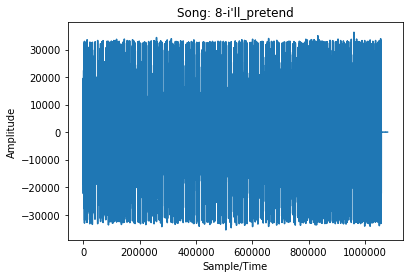

In [16]:
signal, samplingFrequency = read_song(song.filepath)

if(resampleSignal):
    signal = scipy.signal.resample(signal, int(len(signal)/resampleRatio))
    samplingFrequency /= resampleRatio
    
sample_length = combFilterPulses * samplingFrequency
seconds = sample_length * 4
draw_plot(drawPlots, signal, f"Song: {song.name}", "Sample/Time", "Amplitude")
song_length = signal.size

start = int(np.floor(song_length / 2 - seconds / 2))
stop = int(np.floor(song_length / 2 + seconds / 2))
if start < 0:
    start = 0
if stop > song_length:
    stop = song_length

sample = signal[start:stop]

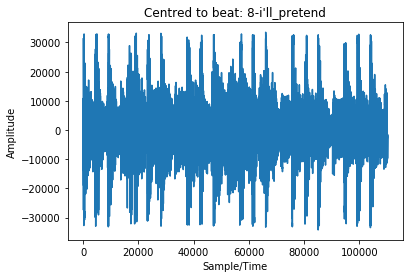

In [17]:
centred = center_sample_to_beat(sample, sample_length)
draw_plot(drawPlots, centred, f"Centred to beat: {song.name}", "Sample/Time", "Amplitude")

Filtering song {song.name}...


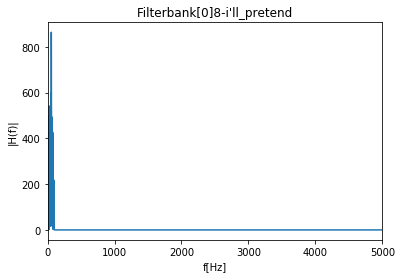

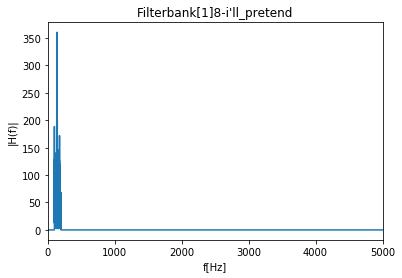

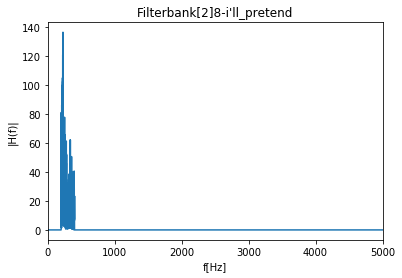

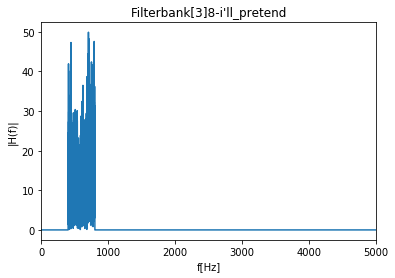

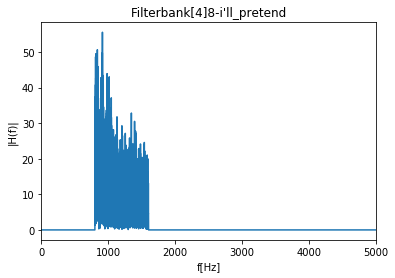

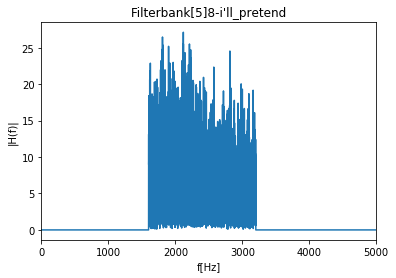

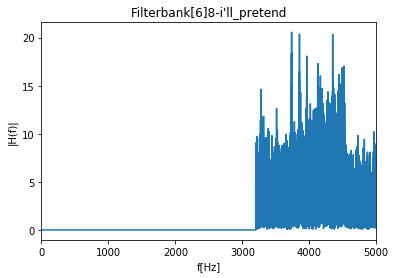

In [18]:
print('Filtering song {song.name}...')
fastFourier = filterbank(centred, bandLimits, samplingFrequency)
for i in range(0, len(bandLimits)):
    draw_fft_plot(drawPlots, fastFourier[i], f"Filterbank[{i}]{song.name}", samplingFrequency)

Windowing song 8-i'll_pretend...


D:\Programsk\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


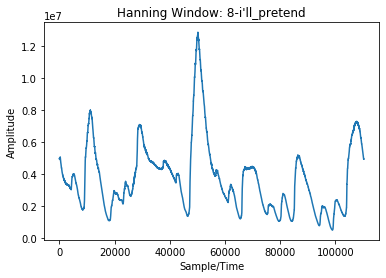

In [19]:
print(f'Windowing song {song.name}...')
hanningWindow = hann(fastFourier, 0.2, bandLimits, samplingFrequency)
draw_plot(drawPlots, hanningWindow[1], f"Hanning Window: {song.name}", "Sample/Time", "Amplitude")

Differentiating song 8-i'll_pretend...


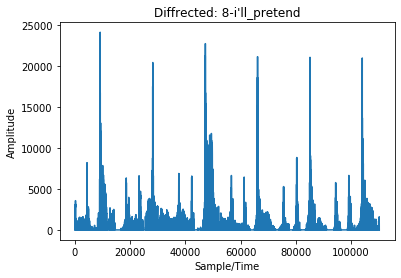

In [20]:
print(f'Differentiating song {song.name}...')
diffrected = diffrect(hanningWindow, len(bandLimits))
draw_plot(drawPlots, diffrected[1], f"Diffrected: {song.name}", "Sample/Time", "Amplitude")

CombFiltering song 8-i'll_pretend...
0.0
2.7777777777777777
5.555555555555555
8.333333333333334
11.11111111111111
13.88888888888889
16.666666666666668
19.444444444444443
22.22222222222222
25.0
27.77777777777778
30.555555555555557
33.333333333333336
36.111111111111114
38.888888888888886
41.666666666666664
44.44444444444444
47.22222222222222
50.0
52.77777777777778
55.55555555555556
58.333333333333336
61.111111111111114
63.888888888888886
66.66666666666667
69.44444444444444
72.22222222222223
75.0
77.77777777777777
80.55555555555556
83.33333333333333
86.11111111111111
88.88888888888889
91.66666666666667
94.44444444444444
97.22222222222223


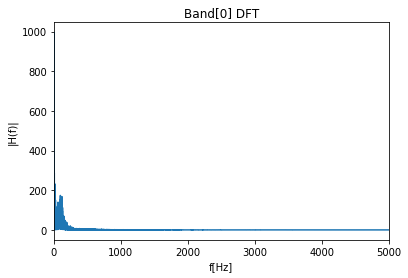

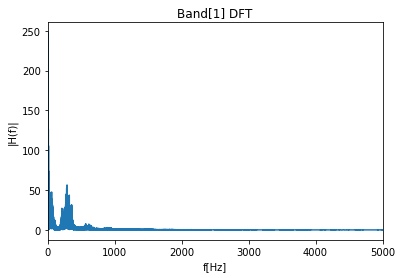

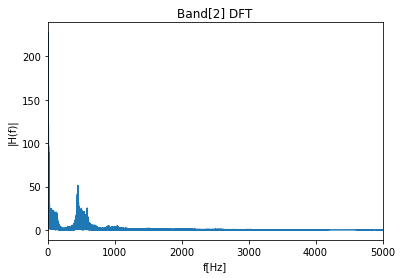

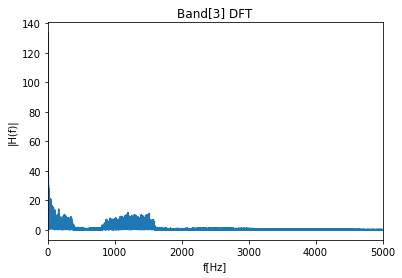

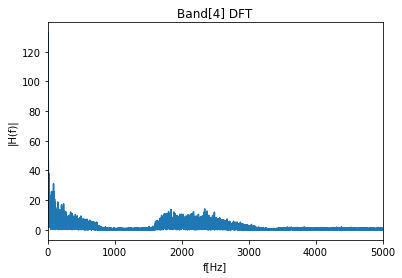

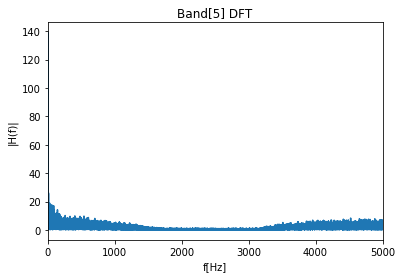

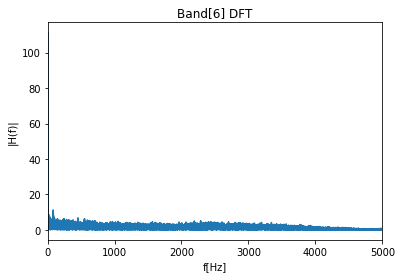

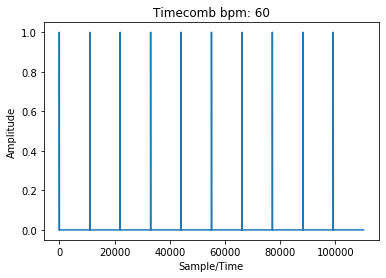

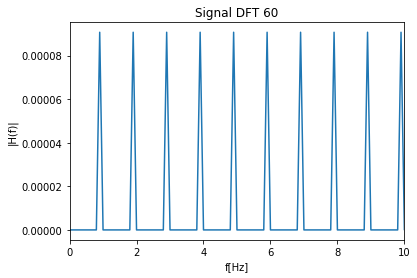

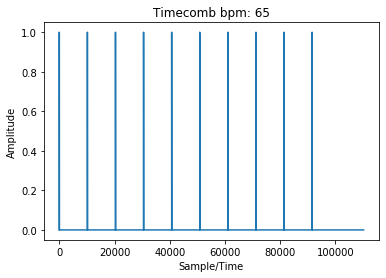

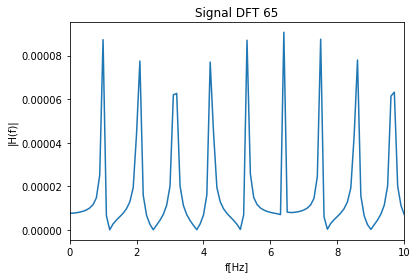

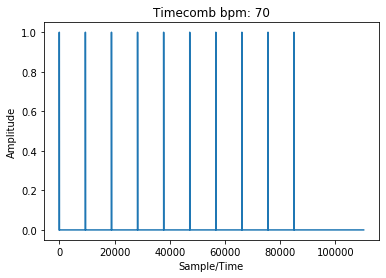

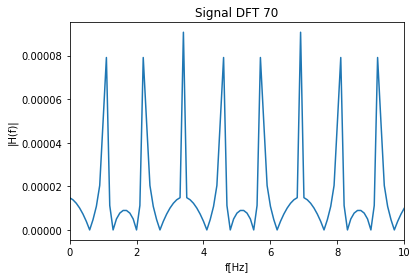

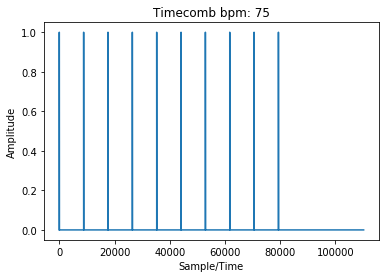

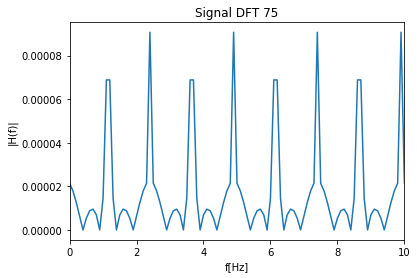

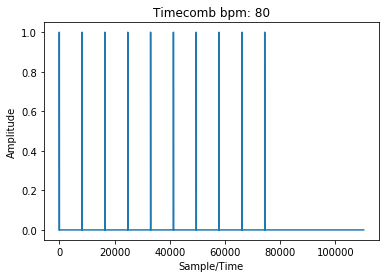

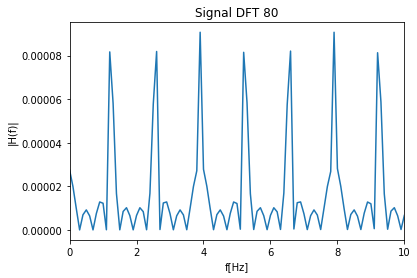

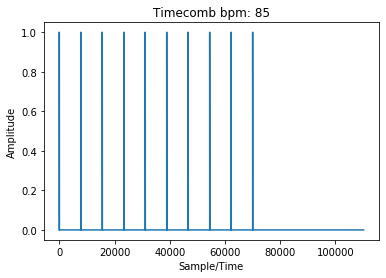

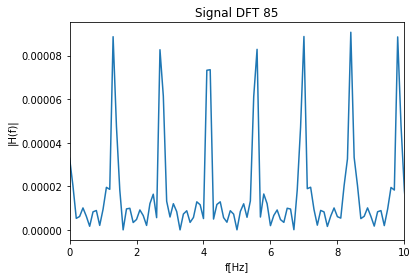

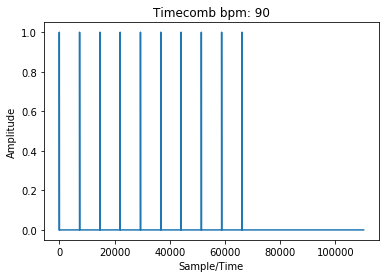

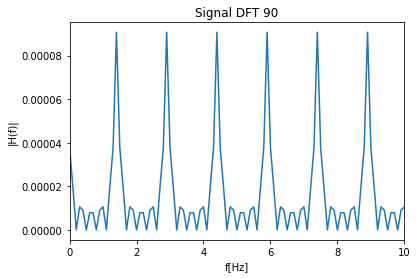

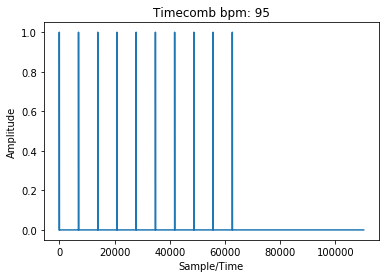

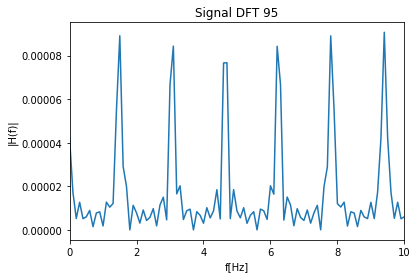

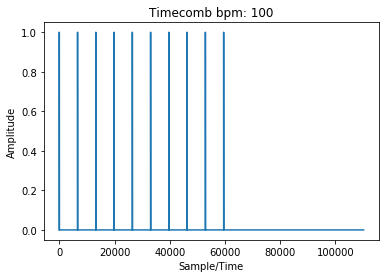

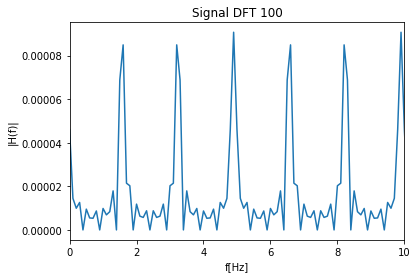

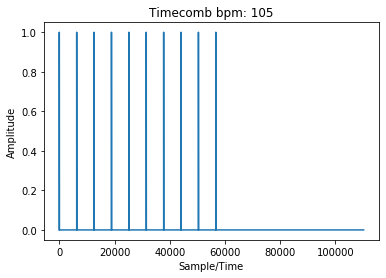

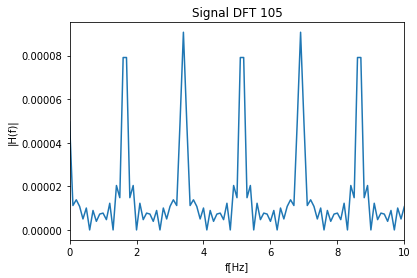

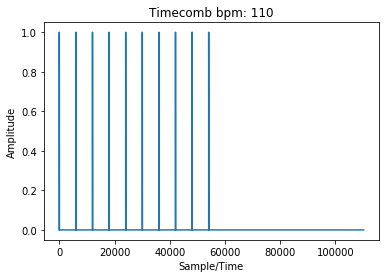

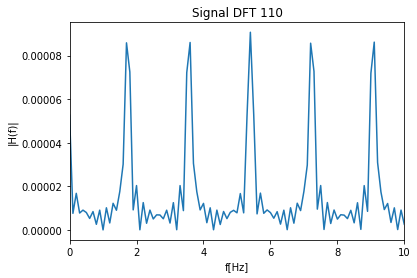

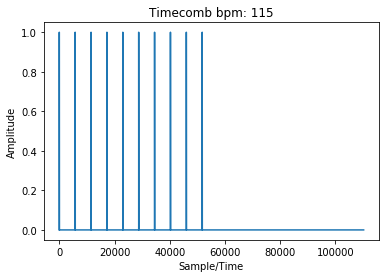

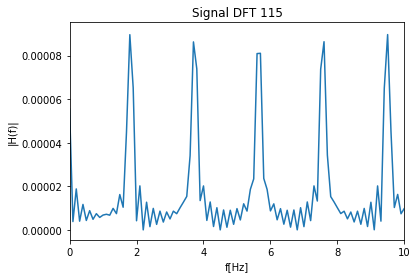

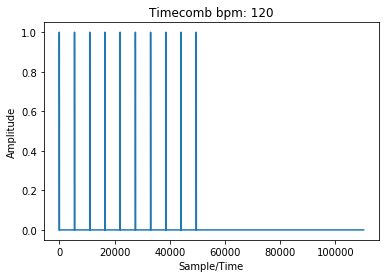

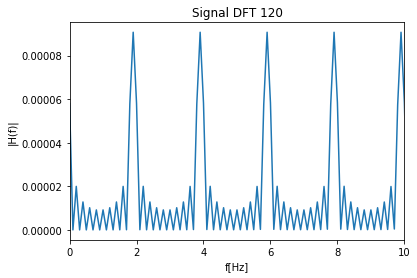

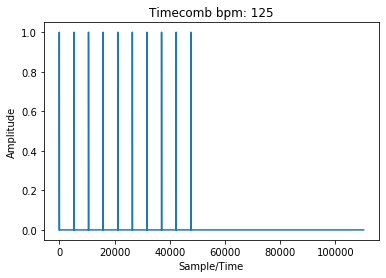

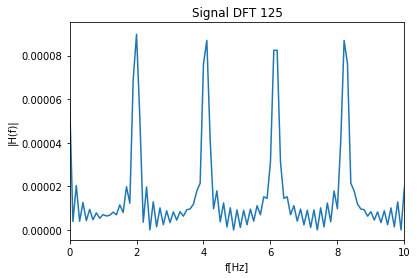

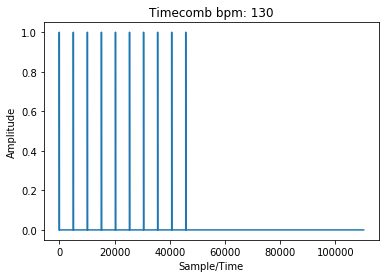

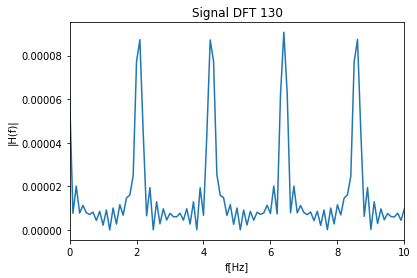

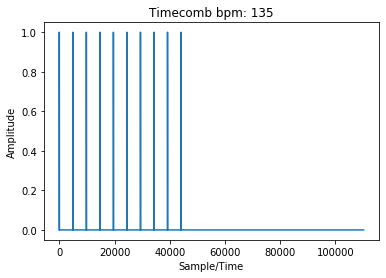

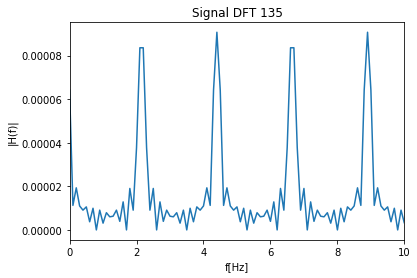

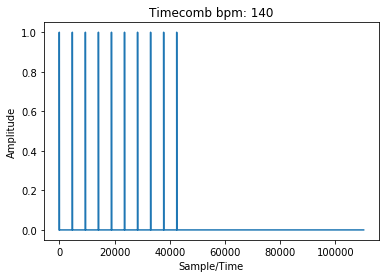

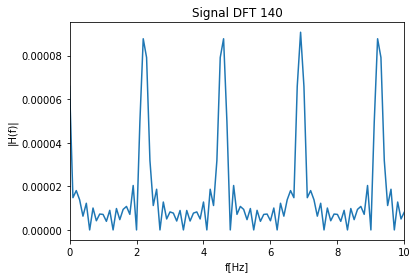

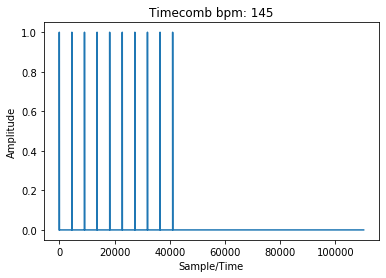

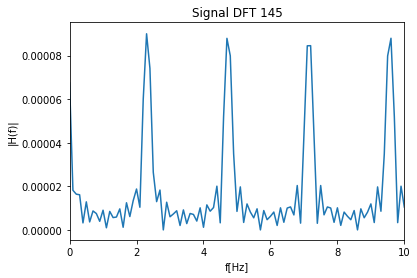

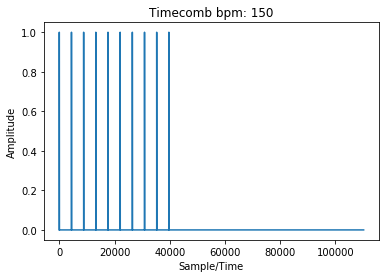

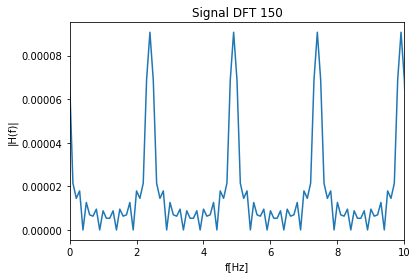

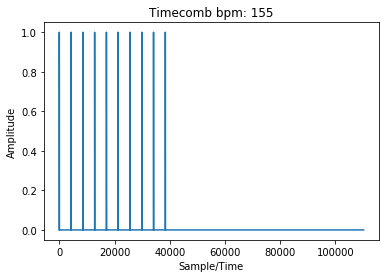

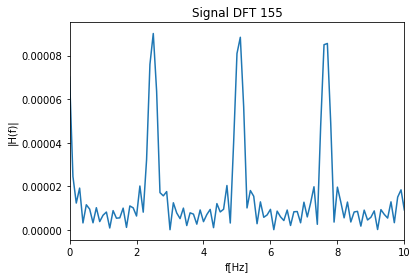

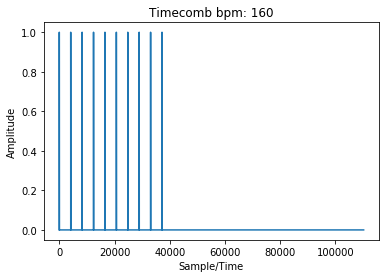

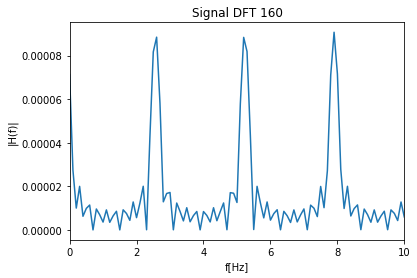

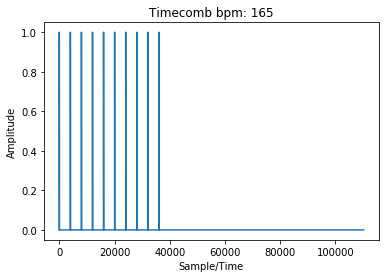

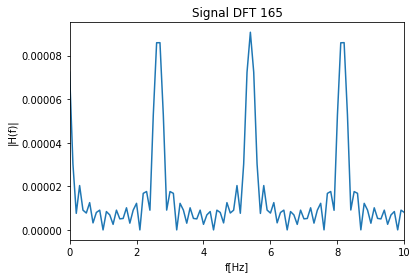

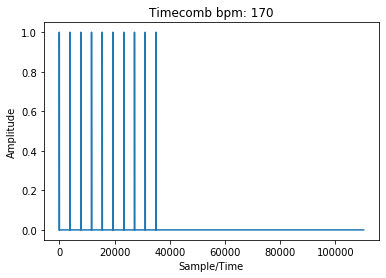

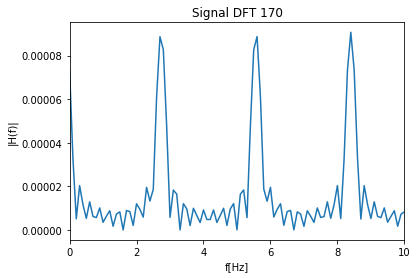

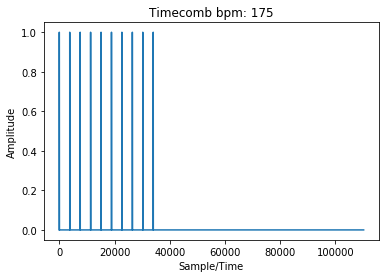

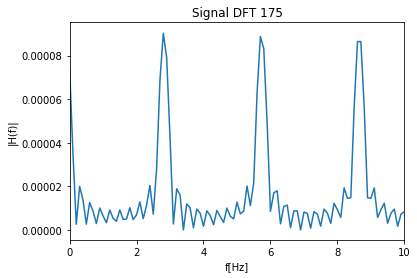

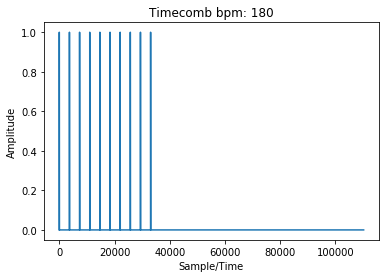

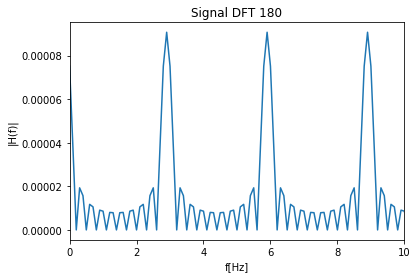

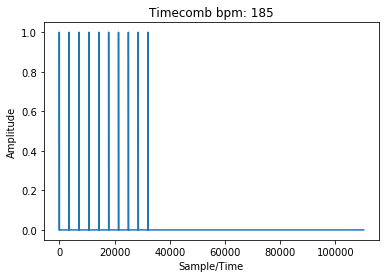

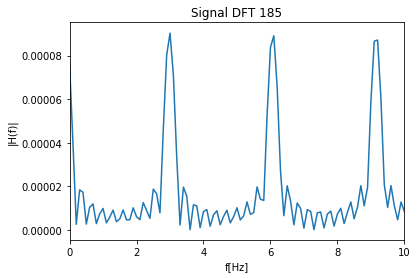

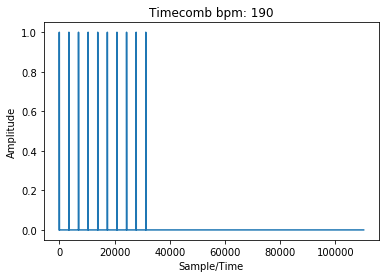

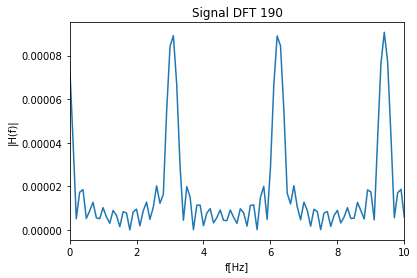

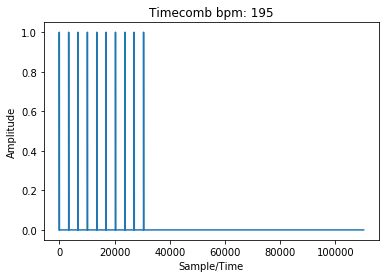

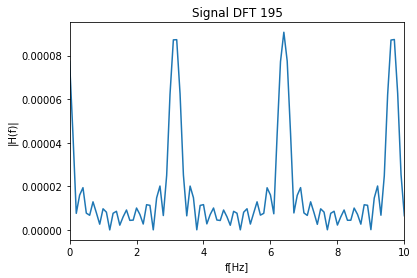

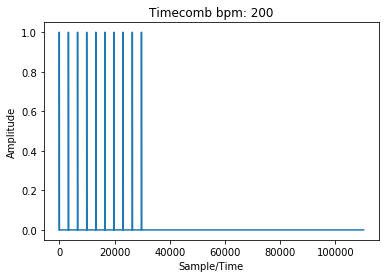

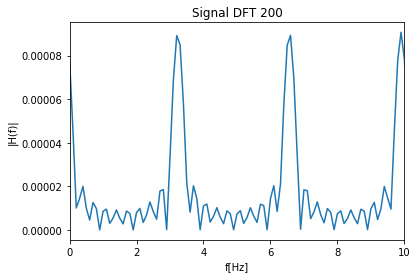

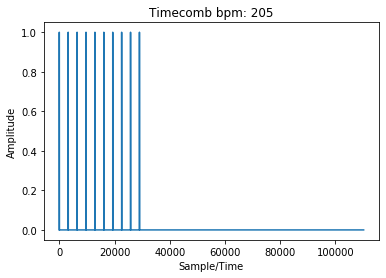

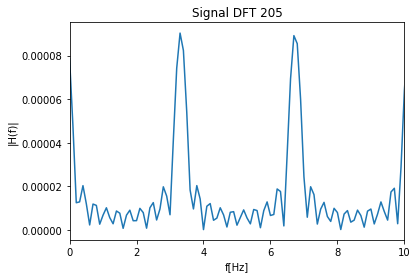

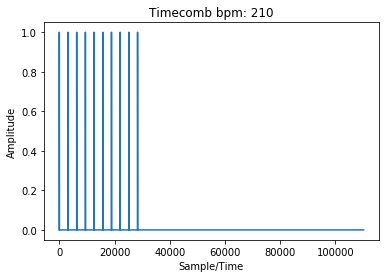

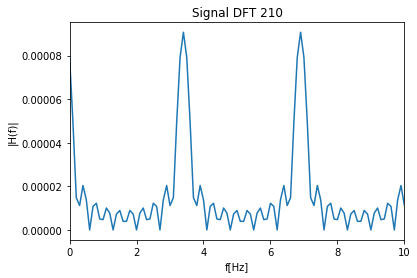

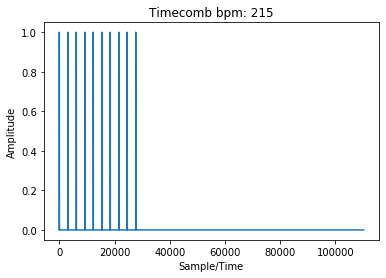

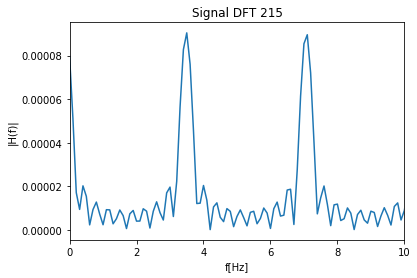

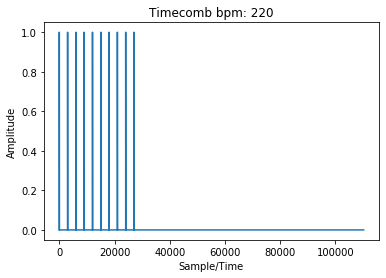

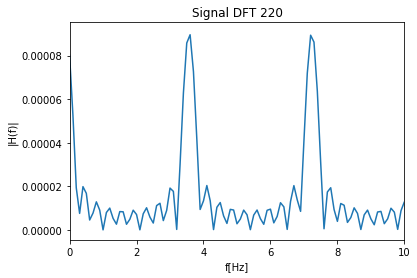

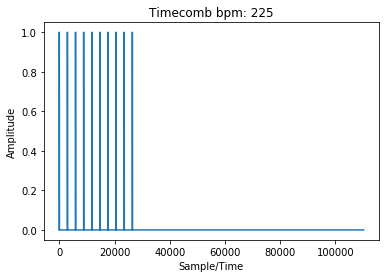

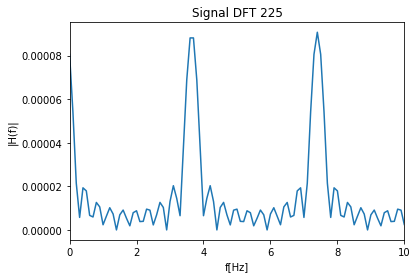

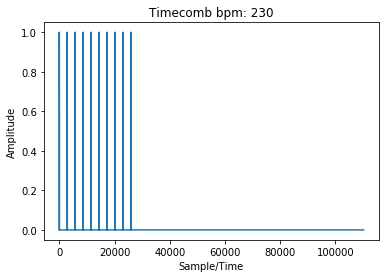

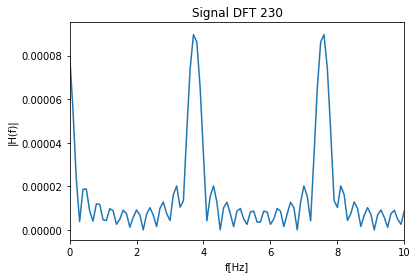

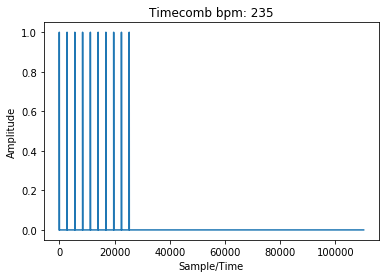

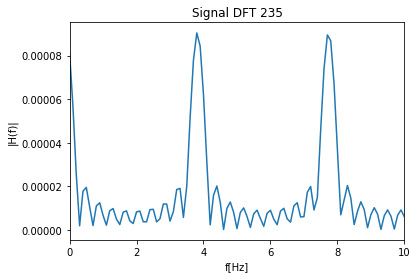

140

In [21]:
print(f'CombFiltering song {song.name}...')
plotDictionary = prepare_plot_dictionary(minBpm, maxBpm)
if useConvolveMethod: 
    first = bpm_comb_filter_convolve(diffrected,
                              5,
                              minBpm,
                              maxBpm,
                              bandLimits,
                              samplingFrequency,
                              plotDictionary)
else:
        first = bpm_comb_filter(diffrected,
                              5,
                              minBpm,
                              maxBpm,
                              bandLimits,
                              samplingFrequency,
                              combFilterPulses,
                              plotDictionary)
first

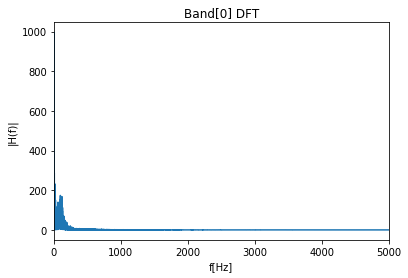

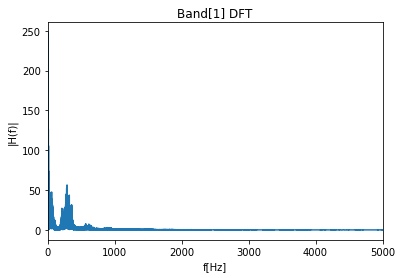

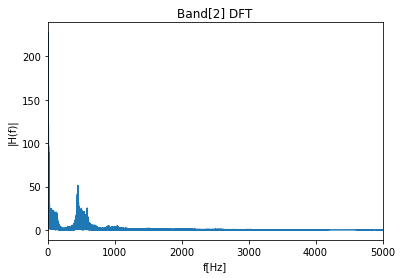

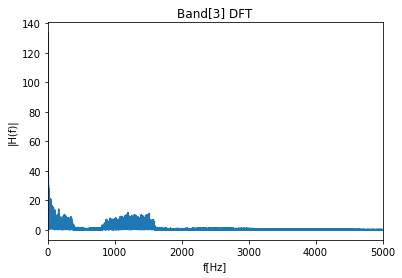

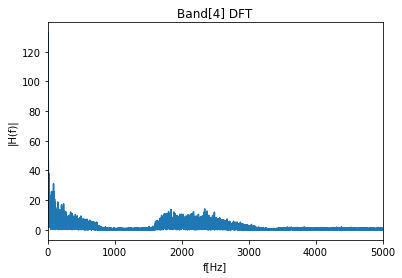

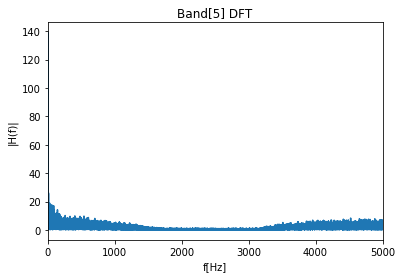

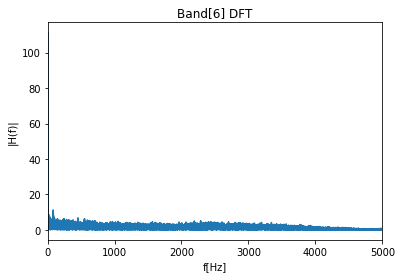

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0


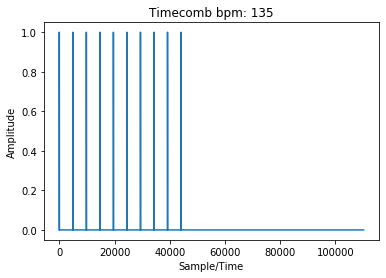

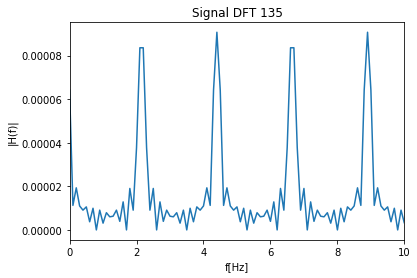

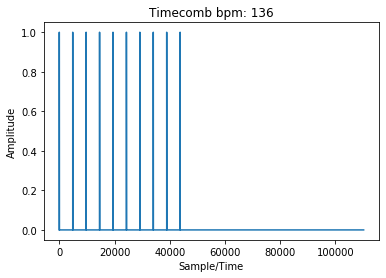

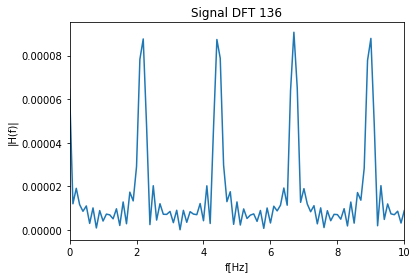

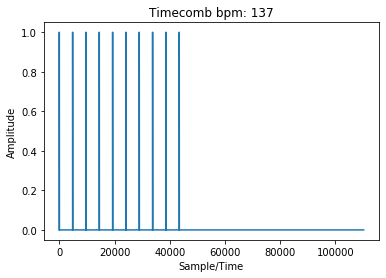

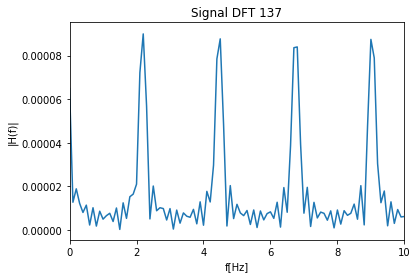

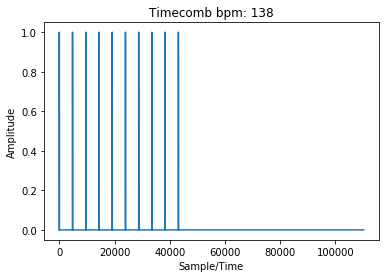

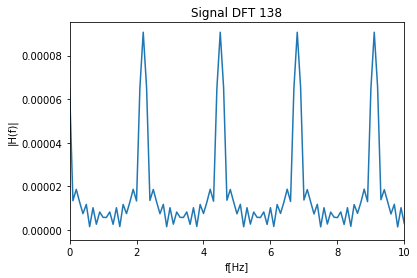

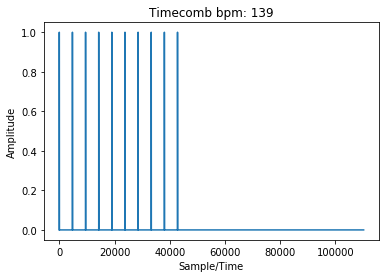

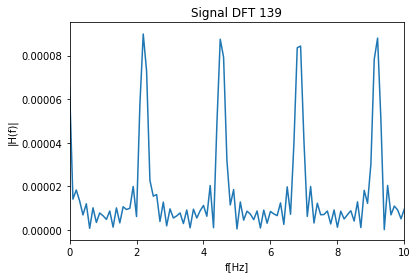

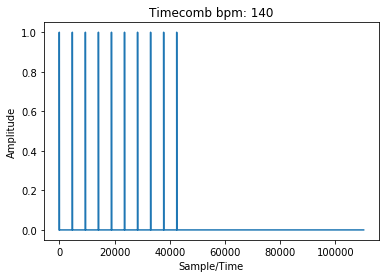

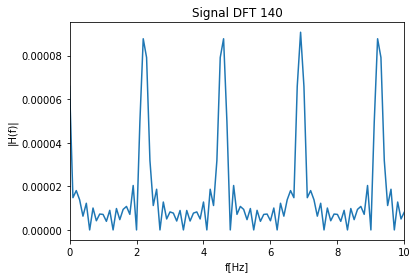

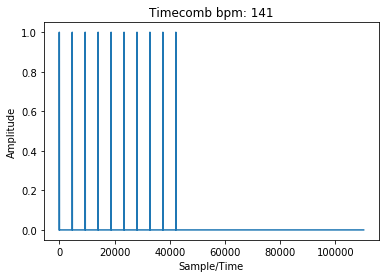

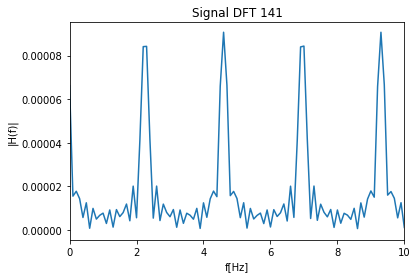

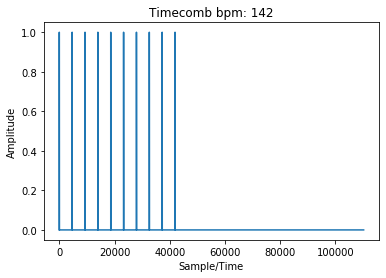

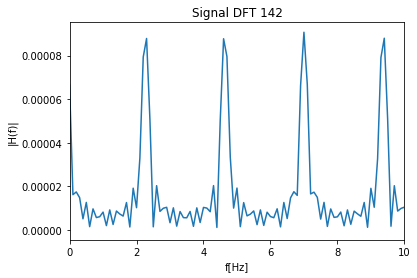

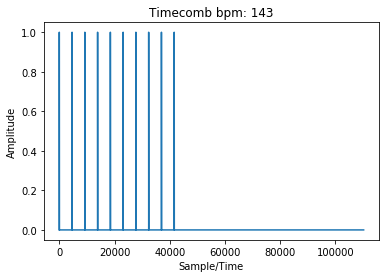

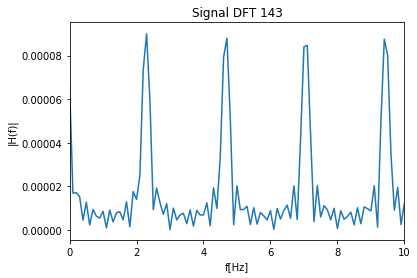

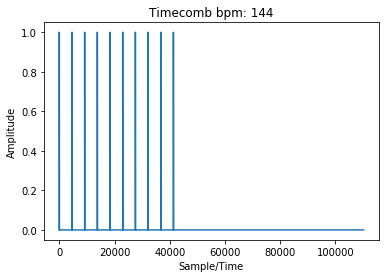

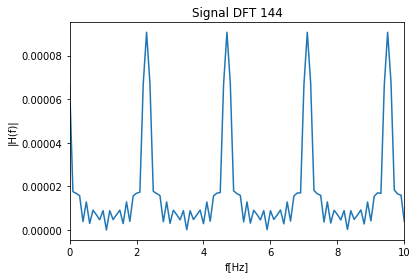

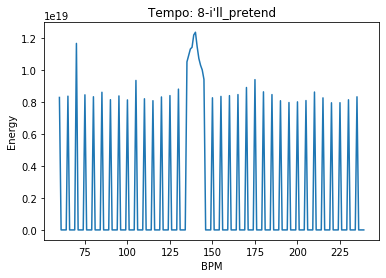

140

In [22]:
if useConvolveMethod:
    song_bpm = bpm_comb_filter_convolve(diffrected, 1, first - 5, first + 5, bandLimits, samplingFrequency, plotDictionary)
else:
    song_bpm = bpm_comb_filter(diffrected, 1, first - 5, first + 5, bandLimits, samplingFrequency, combFilterPulses, plotDictionary)
draw_plot(drawSongBpmEnergyPlot, list(plotDictionary.keys()), f"Tempo: {song.name}", "BPM", "Energy", list(plotDictionary.values()))
song_bpm

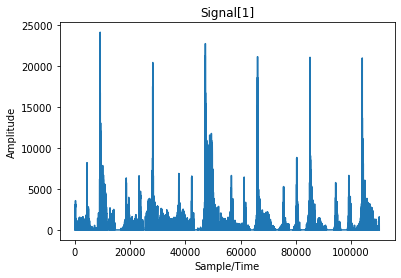

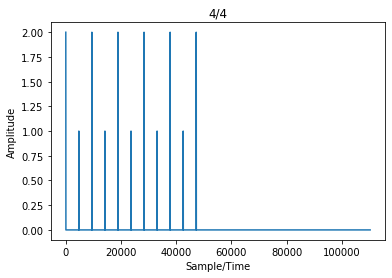

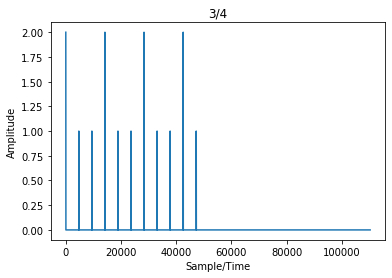

'4/4'

In [23]:
metre = detectMetre(diffrected, song_bpm, bandLimits, samplingFrequency, combFilterPulses)
metre

In [24]:
time = time.time() - startTime
time

40.82015538215637

In [25]:
!jupyter nbconvert --to script TempoMetreDetector.ipynb

[NbConvertApp] Converting notebook TempoMetreDetector.ipynb to script
[NbConvertApp] Writing 14003 bytes to TempoMetreDetector.py
